Para las siguientes simulaciones, se usan los paquetes mostrados a continuación, se añadirán mas para funciones que se requieran.

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numba
from scipy.integrate import odeint

Nuestro caso de estudio es el modelo SIR epidémico, que describe el comportamiento de transmisión tomando como únicos vectores los individuos infectados, y además considerando la inmunidad adquirida después de cierto tiempo, a continuación usamos el método odeint que nos da una solución numérica a una ecuación diferencial usando el método de Gauss, sería interesante ver la diferencia de este método iterativo con Runge Kutta 4

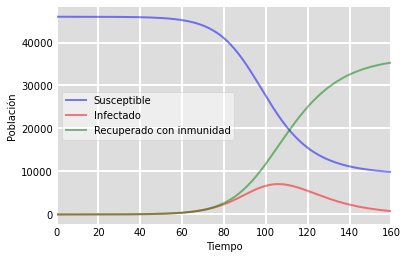

In [77]:
from scipy.integrate import odeint
N = 46000
I0, R0 = 1, 0
S0 = N - I0 - R0
beta, gamma = 0.2, 1./10 
# Definimos las condiciones iniciales como sigue 
t = np.linspace(0, 160, 250)
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
y0 = S0, I0, R0
# Calculamos la integral que corresponde a la solución del sistema
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
# Graficamos
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectado')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperado con inmunidad')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Población')
ax.set_xlim(0,160)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [2]:
rang=np.linspace(0.001,1,1000)
def func(S_o,R_o,x):
    return (1/R_o)*np.log(x/S_o)-x+1

## Punto 1
Para la expresión encontrada en el primer punto, la relación corresponde a esta gráfica al variar $S_o$ y con $R_o=5$ fijo

<Figure size 720x432 with 0 Axes>

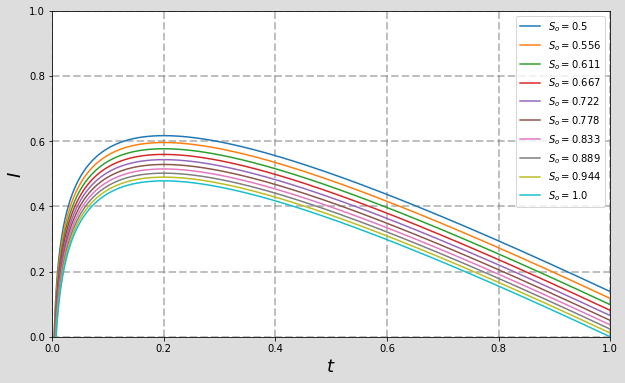

In [83]:
plt.figure(figsize=(10,6))
s0=np.linspace(0.5,1,10)
plt.figure(figsize=(10,6),facecolor='#dddddd')
for i in s0:
    labl=str(np.round(i,3))
    plt.plot(rang,func(i,5,rang), label="$S_o= $" + labl)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("$t$",fontsize="18")
plt.ylabel("$I$",fontsize="18")
plt.legend()
plt.grid(c='gray', lw=2, ls='--',alpha=0.5)

Para la expresión encontrada en el primer punto, la relación corresponde a esta gráfica al variar $R_o$ y con $S_o=1$ fijo

<Figure size 720x432 with 0 Axes>

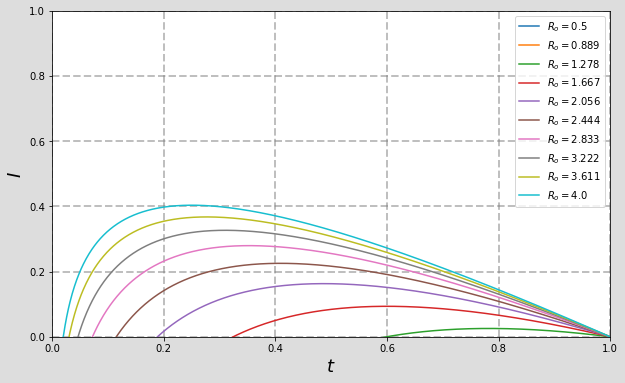

In [88]:
plt.figure(figsize=(10,6))
R0=np.linspace(0.5,4,10)
plt.figure(figsize=(10,6),facecolor='#dddddd')
for i in R0:
    labl=str(np.round(i,3))
    plt.plot(rang,func(1,i,rang), label="$R_o= $" + labl)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("$t$",fontsize="18")
plt.ylabel("$I$",fontsize="18")
plt.legend()
plt.grid(c='gray', lw=2, ls='--',alpha=0.5)

In [4]:
def func2(A,B,r):
    return 1-B*np.e**(-A*r)-r

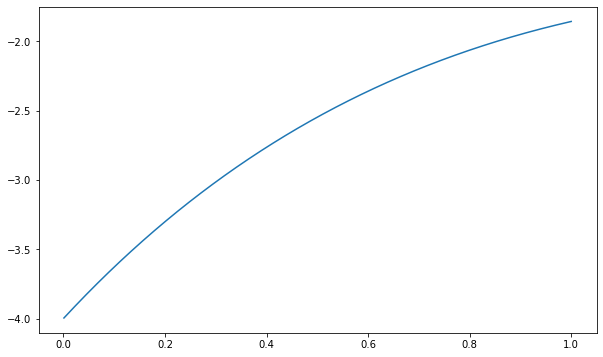

In [5]:
plt.figure(figsize=(10,6))
plt.plot(rang,func2(0.99,5,rang))

In [6]:
np.e

2.718281828459045

In [87]:
max(func(1,1,rang))

0.0

Esta parte corresponde a los otros numerales del primer punto y el punto dos, recuerde que podemos reducir el sistema de ecuaciones expresando así el modelo en términos de $I(R),S(R)$

In [89]:
def frS(r,S_o=1,R_o=5):
    return S_o*np.e**(-R_o*r)

def frI(r,S_o=1,R_o=5):
    return 1-S_o*np.e**(-R_o*r)-r

def frR(r,S_o=1,R_o=5):
    return r

En la siguiente gráfica se muestra la distribución de $I$ y $S$ respecto a $R$ para distintos valores de $R_o$. Además, se muestra que el máximo correspondiente a $I$ con $R_o$ se encuentra donde se espera siguiendo las soluciones encontradas en el documento 

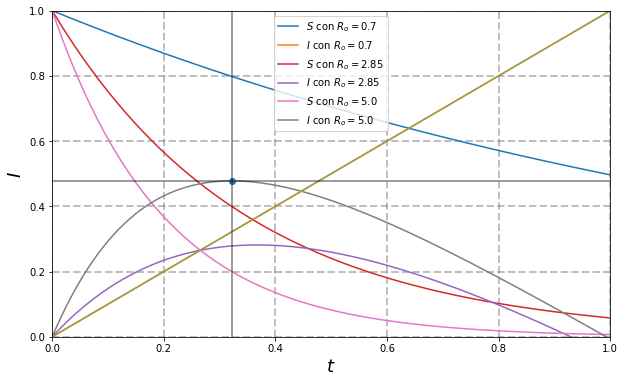

In [107]:
plt.figure(figsize=(10,6))
newR0=np.linspace(0.7,5,3)
for i in newR0:
    labl=str(np.round(i,3))
    plt.plot(rang,frS(rang,1,i), label="$S$ con $R_o= $" + labl,alpha=1)
    plt.plot(rang,frI(rang,1,i),label="$I$ con $R_o= $" + labl,alpha=1)
    plt.plot(rang,frR(rang,1,i),alpha=i/3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("$t$",fontsize="18")
plt.ylabel("$I$",fontsize="18")
plt.legend()
plt.grid(c='gray', lw=2, ls='--',alpha=0.5)
plt.axvline(x=np.log(1*5)/5,color="black",alpha=0.5)
plt.axhline(y=1-1/5-np.log(1*5)/5,color="black",alpha=0.5)
plt.scatter(x=np.log(1*5)/5,y=1-1/5-np.log(1*5)/5)
plt.legend()


Esta sección se usará para definir el método de iteración Newton Raphson, para ello, es necesario definir la derivada y vamos a usar derivada central para este propósito

In [108]:
def derivative(X,Y):
    arr=[]
    for i in range(1,len(X)-1):
        prime=(Y[i+1]-Y[i-1])/(2*(X[i+1]-X[i]))
        arr.append(prime)
    return np.asarray(X[1:len(X)-1]),np.asarray(arr)
        
def derivativeone(f,a,h=0.001):
    return (f(a + h) - f(a - h))/(2*h)
        



Probamos el método para coseno, donde su gráfica correspondiente debería ser la gráfica de seno

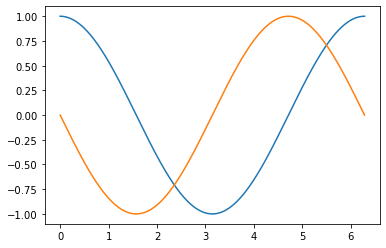

In [109]:
exx=np.linspace(0,2*np.pi,10000)
yy=np.cos(exx)
plt.plot(exx,yy)
plt.plot(derivative(exx,yy)[0],derivative(exx,yy)[1])

Ahora, definimos newton Raphson iterativamente, donde la condición de halt es un threshold cercano a cero pero no exactamente cero, se elige $10^{-14}$ para este proceso

In [112]:
def newtRh(X,x_o,tol,f):
    x_act=x_o
    y=0
    #print(derivative(X,f(X))[1][99-1])
    while np.abs(f(x_act))>tol:
        x_next=x_act-(f(x_act))/(derivativeone(f,x_act))
        x_act=x_next
        y=f(x_act)
    return x_act,y

Donde al variar el $x_o$ encontramos dos ceros que corresponden también a la gráfica del máximo
$$
I(0)=0 , I(1)=0
$$

In [113]:
newtRh(rang,1,1e-14,frI)

(0.9930228463488553, 0.0)

In [114]:
newtRh(rang,0,1e-14,frI)

(0, 0)

## Punto 5

Definimos las aproximaciones encontradas en el punto 4

In [15]:
from scipy.special import lambertw
import warnings
warnings.filterwarnings('ignore')

def AprW(R_o,S_o):
    return (R_o-lambertw(S_o*R_o*lambertw(np.e**R_o),k=1))/R_o
def AprExp(R_o,S_o):
    return ((1-S_o*R_o)+np.sqrt(2*(1-S_o)*S_o*R_o**2+(R_o*S_o-1)**2))/(S_o*R_o**2)
    
    

Que nos dan el siguiente gráfico, note que ambas convergen a cero rápidamente cuando $R_o$ aumenta y es mayor a 1. Sin embargo, es evidente que la aproximación exponencial converge más rápido

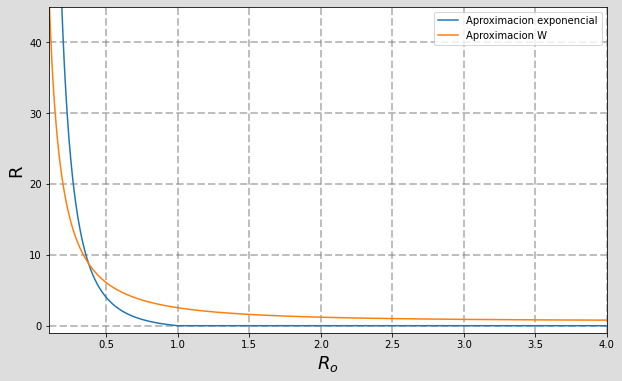

In [115]:
reprod=np.linspace(0.1,4,10000)

plt.figure(figsize=(10,6),facecolor='#dddddd')
plt.plot(reprod,AprExp(reprod,1), label="Aproximacion exponencial")
plt.plot(reprod,AprW(reprod,1) , label="Aproximacion W")
plt.xlim(0.1,4)
plt.ylim(-1,45)
plt.xlabel("$R_o$",fontsize="18")
plt.ylabel("R",fontsize="18")
plt.legend()
plt.grid(c='gray', lw=2, ls='--',alpha=0.5)

Haciendo el mismo ejercicio para diferentes valores de $S_o$ para el caso exponencial

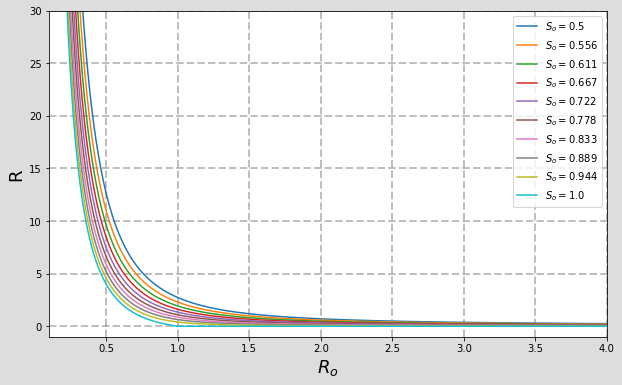

In [116]:
s0=np.linspace(0.5,1,10)
plt.figure(figsize=(10,6),facecolor='#dddddd')
for i in s0:
    labl=str(np.round(i,3))
    plt.plot(reprod,AprExp(reprod,i), label="$S_o= $" + labl)
plt.xlim(0.1,4)
plt.ylim(-1,30)
plt.xlabel("$R_o$",fontsize="18")
plt.ylabel("R",fontsize="18")
plt.legend()
plt.grid(c='gray', lw=2, ls='--',alpha=0.5)

y para el caso de la aproximación a la función de Lambert

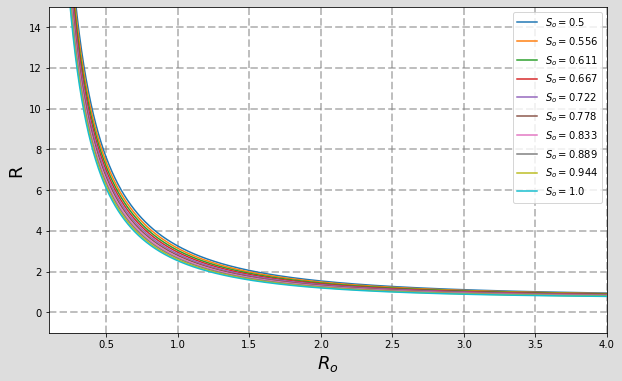

In [117]:
plt.figure(figsize=(10,6),facecolor='#dddddd')
for i in s0:
    labl=str(np.round(i,3))
    plt.plot(reprod,AprW(reprod,i),label="$S_o= $" + labl)
plt.xlim(0.1,4)
plt.ylim(-1,15)
plt.xlabel("$R_o$",fontsize="18")
plt.ylabel("R",fontsize="18")
plt.legend()
plt.grid(c='gray', lw=2, ls='--',alpha=0.5)